In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_file_path = '/content/drive/MyDrive/OSCD.zip'
dataset_folder = '/content/drive/MyDrive/OSCD/'

if len(os.listdir(dataset_folder)) == 0:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_folder)

  print(f"Unzipped to: {dataset_folder}")

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pathlib

dataset = pathlib.Path(os.path.join(dataset_folder, 'labelme'))
images_files = list(dataset.glob('**/*.jpg'))
annotations_files = list(dataset.glob('**/*.json'))


In [74]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.tv_tensors import Mask, BoundingBoxes
from torchvision.transforms.v2 import functional as F
import json
from torchvision import transforms
import torchvision

from PIL import Image, ImageDraw

class OSCDDataset(Dataset):
  def __init__(self, images_files, annotations_files, transforms=None):
    super().__init__()
    self._file_keys = [i.stem for i in images_files]
    self._images_files = {i.stem: i for i in images_files}
    self._annotations_files = {a.stem: a for a in annotations_files}
    self._transforms = transforms

  def __len__(self):
    return len(self._file_keys)

  def __getitem__(self, idx):
    file_key = self._file_keys[idx]
    image, annotations_dict = self._read_data(file_key)
    shapes = annotations_dict['shapes']
    if len(shapes) == 0:
      target = self._get_background_only_target(image)
      pass
    else:
      target = self._get_target(image, shapes)

    if self._transforms:
      image = self._transforms(image)

    return image, target

  def _read_data(self, file_key):
    image_file = self._images_files[file_key]
    image = Image.open(image_file).convert('RGB')

    annotations_file = self._annotations_files[file_key]
    with open(annotations_file, 'r') as f:
      annotations_dict = json.load(f)
    return image, annotations_dict

  def _get_background_only_target(self, image):
    mask_img = Image.new('L', image.size, 0)
    # negative_mask = Mask(mask_img, dtype=torch.bool)
    # bboxes = tv_tensors.BoundingBoxes([0, 0, image.size[0], image.size[1]], format="XYXY", canvas_size=F.get_size(image))
    # area = torch.tensor((image.size[0] * image.size[1]), dtype=torch.float32)
    target = {
        'boxes': torch.zeros((0, 4), dtype=torch.float32),
        'labels': torch.zeros(0, dtype=torch.int64),
        'masks': torch.zeros((0, image.size[1], image.size[0]), dtype=torch.bool),
        'area': torch.zeros(0, dtype=torch.float32),
        'iscrowd': torch.zeros(0, dtype=torch.int64),
    }
    return target

  def _get_target(self, image, shapes):
    labels = torch.ones((len(shapes), ), dtype=torch.int64)
    shape_points = [shape['points'] for shape in shapes]
    xy_coords = [[tuple(p) for p in points] for points in shape_points]
    ### masks
    masks = Mask(torch.concat([self._create_polygon_mask(image.size, xy) for xy in xy_coords]))
    boxes = masks_to_boxes(masks)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((len(shapes),), dtype=torch.int64)
    bboxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
    target = {
        'boxes': bboxes,
        'labels': labels,
        'masks': Mask(masks),
        'area': area,
        'iscrowd': iscrowd
    }
    return target

  def _create_polygon_mask(self, image_size, vertices):
    mask_img = Image.new('L', image_size, 0)
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))
    mask = Mask(mask_img, dtype=torch.bool)
    return mask

In [75]:
dataset = OSCDDataset(images_files, annotations_files, transforms=None)
dataset_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn= lambda batch: tuple(zip(*batch)), num_workers=2)

In [68]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

model_path = os.path.join(dataset_folder, 'model/model_sldd41do_20.pth')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model.to(device)
model.train()
print("t")

t


loaded
179


In [86]:
from torchvision.transforms import v2
from torchvision import tv_tensors


images_files_dict = {img_file.stem: i for i, img_file in enumerate(images_files)}
idx = images_files_dict["net (904)"]
img_no_boxes, target_no_boxes = dataset[idx]
img, target = dataset[0]
print("loaded")
print(idx)
mask = torch.zeros((0, img_no_boxes.size[1], img_no_boxes.size[0]), dtype=torch.bool)
target_no_boxes = {
        'boxes': torch.zeros((0, 4), dtype=torch.float32),
        'labels': torch.zeros(0, dtype=torch.int64),
        'masks': mask,
        'area': torch.zeros(0, dtype=torch.float32),
        'iscrowd': torch.zeros(0, dtype=torch.int64),
    }


img_no_boxes = tv_tensors.Image(img_no_boxes)
img_no_boxes = v2.ToDtype(torch.float, scale=True)(img_no_boxes)
img_no_boxes = v2.ToPureTensor()(img_no_boxes)

target_no_boxes = v2.ToDtype(torch.float, scale=True)(target_no_boxes)
target_no_boxes = v2.ToPureTensor()(target_no_boxes)

img = tv_tensors.Image(img)
img = v2.ToDtype(torch.float, scale=True)(img)
img = v2.ToPureTensor()(img)


with torch.no_grad():
  loss = model([img_no_boxes, img], [target_no_boxes, target])


loaded
179


In [87]:
model.eval()
preds = model([img])

torch.Size([64, 300, 530])

In [92]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

masks = (pred["masks"] > 0.9).squeeze(1)
plt_img = draw_bounding_boxes(img_no_boxes, preds[0]["boxes"], colors="red")
plt_img = draw_segmentation_masks(plt_img, masks, alpha=0.5, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(plt_img.permute(1, 2, 0))

ValueError: The masks must be of dtype bool. Got torch.float32

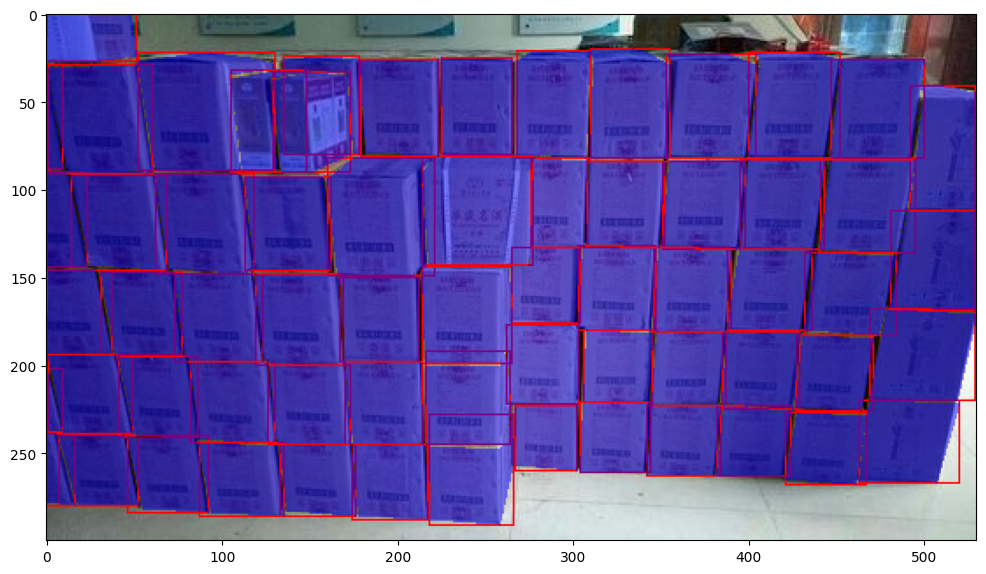

In [ ]:
plt_img = draw_bounding_boxes(img, target["boxes"], colors="red")
plt_img = draw_segmentation_masks(plt_img, target["masks"], alpha=0.5, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(plt_img.permute(1, 2, 0))